In [12]:
import os
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import sys
import tensorflow as tf
import time
from pylab import *
import pickle
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from skimage.util.shape import view_as_windows
from sklearn.metrics import roc_curve,roc_auc_score
from tcn import TCN, tcn_full_summary
from tensorflow.keras.layers import Dense, Conv2D, Layer, Lambda, Flatten
from tensorflow.keras import Input, Model, metrics
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.python.client import device_lib

module_path = os.path.abspath(os.path.join('..'))
project_path = os.path.abspath(os.path.join('../..'))
train_source = os.path.abspath(os.path.join('../../data/train_source/'))
test_source = os.path.abspath(os.path.join('../../data/test_source/'))
train_path = os.path.abspath(os.path.join('../../data/train/'))
test_path = os.path.abspath(os.path.join('../../data/test/'))
dest_path_bsu = os.path.abspath(os.path.join('../../data/final_bsu/'))
dest_path_bs = os.path.abspath(os.path.join('../../data/final_bs/'))
val_path_bs = os.path.abspath(os.path.join('../../data/validation_bs/'))
val_path_bsu = os.path.abspath(os.path.join('../../data/validation_bsu/'))

if module_path not in sys.path:
    sys.path.append(module_path)
if project_path not in sys.path:
    sys.path.append(project_path)
    
np.set_printoptions(suppress=True)
np.set_printoptions(threshold=sys.maxsize)
#print(device_lib.list_local_devices())

In [2]:
# Hyperparameters
nb_classes=2
cols, rows = 2, 30
input_shape = (cols, rows, 1)
vol_imb_diff = 0.1
evaluate_every = 100 # interval for evaluating on one-shot tasks
batch_size = 32
n_iter = 20000 # No. of training iterations
n_val = 250 # how many one-shot tasks to validate on
h = 30
w = 2
d = 2

In [3]:
num_frames = 10
# FOR BS Training 
# Train
X_train = np.load(dest_path_bs + '/' + str(num_frames) + '_X_train.npy')
Y_train = np.load(dest_path_bs + '/' + str(num_frames) + '_Y_train.npy')
F_train = np.load(dest_path_bs + '/' + str(num_frames) + '_F_train.npy')
X_test = np.load(dest_path_bs + '/' + str(num_frames) + '_X_test.npy')
Y_test = np.load(dest_path_bs + '/' + str(num_frames) + '_Y_test.npy')
F_test = np.load(dest_path_bs + '/' + str(num_frames) + '_F_test.npy')

print(X_train.shape)
print(X_test.shape)

#X_train = np.append(X_train, X_test, axis=0)
#Y_train = np.append(Y_train, Y_test, axis=0)
#F_train = np.append(F_train, F_test, axis=0)
#print(X_train.shape)

# Validation
X_val = np.load(val_path_bs + '/' + str(num_frames) + '_X_val.npy')
Y_val = np.load(val_path_bs + '/' + str(num_frames) + '_Y_val.npy')
print(X_val.shape)

(265825, 10, 30, 2, 2)
(93741, 10, 30, 2, 2)
(19733, 10, 30, 2, 2)


In [15]:
history_retrieve = pickle.load(open(os.path.abspath(os.path.join('../../results/2/')), "rb"))

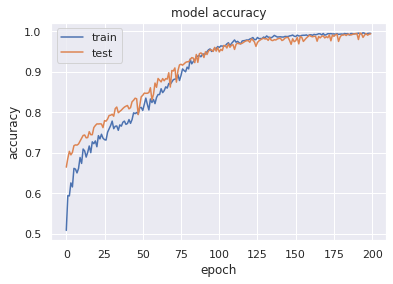

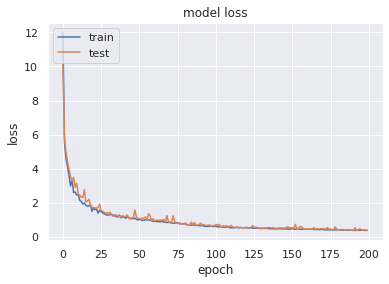

In [16]:
# summarize history for accuracy
plt.plot(history_retrieve['acc'])
plt.plot(history_retrieve['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_retrieve['loss'])
plt.plot(history_retrieve['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
from scipy.spatial import distance

def compute_dist(a,b):
    return distance.cityblock(a,b)
    #return distance.correlation(a,b) -- NOT GOOD
    #return distance.cosine(a,b) -- NOT GOOD
    
    #return distance.euclidean(a,b)

    # Standard distance used 
    #return np.sum(np.square(a-b))

def compute_metrics(probs, yprobs):
    '''
    Returns
        fpr : Increasing false positive rates such that element i is the false positive 
        rate of predictions with score >= thresholds[i]
        tpr : Increasing true positive rates such that element i is the true positive rate of 
        predictions with score >= thresholds[i].
        thresholds : Decreasing thresholds on the decision function used to compute fpr and tpr. 
        thresholds[0] represents no 
        instances being predicted and is arbitrarily set to max(y_score) + 1
        auc : Area Under the ROC Curve metric
    '''
    # calculate AUC
    auc = roc_auc_score(yprobs, probs)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(yprobs, probs)
   
    return fpr, tpr, thresholds, auc

def compute_interdist(network):
    '''
    Computes sum of distances between all classes embeddings on our reference test image: 
        d(0,1) + d(0,2) + ... + d(0,9) + d(1,2) + d(1,3) + ... d(8,9)
        A good model should have a large distance between all theses embeddings
        
    Returns:
        array of shape (nb_classes,nb_classes) 
    '''
    res = np.zeros((nb_classes,nb_classes))
    
    ref_images = np.zeros((nb_classes, num_frames, rows, cols, d))
    
    #generates embeddings for reference images
    for i in range(nb_classes):
        ref_images[i,:,:,:] = X_test[i,:,:,:,:]
    ref_embeddings = network.predict(ref_images)
    
    for i in range(nb_classes):
        for j in range(nb_classes):
            res[i,j] = compute_dist(ref_embeddings[i],ref_embeddings[j])
    return res

def draw_interdist(network, n_iteration):
    interdist = compute_interdist(network)
    
    data = []
    for i in range(nb_classes):
        data.append(np.delete(interdist[i,:],[i]))

    fig, ax = plt.subplots()
    ax.set_title('Evaluating embeddings distance from each other after {0} iterations'.format(n_iteration))
    ax.set_ylim([0,3])
    plt.xlabel('Classes')
    plt.ylabel('Distance')
    ax.boxplot(data,showfliers=False,showbox=True)
    locs, labels = plt.xticks()
    plt.xticks(locs,np.arange(nb_classes))
    plt.show()
    
def find_nearest(array, value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1],idx-1
    else:
        return array[idx],idx
    
def draw_roc(fpr, tpr,thresholds, auc):
    #find threshold
    targetfpr=0.1
    _, idx = find_nearest(fpr, targetfpr)
    threshold = thresholds[idx]
    recall = tpr[idx]
    
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    plt.title('AUC: {0:.3f}'.format(auc))
    # show the plot
    plt.show()
    
def compute_probs(network, X, Y):
    '''
    Input
        network : current NN to compute embeddings
        X : tensor of shape (m, num_frame, h, w, 1) containing pics to evaluate
        Y : tensor of shape (m,) containing true class
        
    Returns
        probs : array of shape (m,m) containing distances
    
    '''
    m = X.shape[0]
    nbevaluation = int(m*(m-1)/2)
    probs = np.zeros((nbevaluation))
    y = np.zeros((nbevaluation))
    
    #Compute all embeddings for all pics with current network
    embeddings = network.predict(X)
    
    size_embedding = embeddings.shape[1]
    
    #For each pics of our dataset
    k = 0
    for i in range(m):
            #Against all other images
            for j in range(i+1,m):
                #compute the probability of being the right decision : it should be 1 for 
                # right class, 0 for all other classes
                probs[k] = -compute_dist(embeddings[i,:],embeddings[j,:])
               # print(probs[k])
                if (Y[i]==Y[j]):
                    y[k] = 1
                    #print("{3}:{0} vs {1} : {2}\tSAME".format(i,j,probs[k],k))
                else:
                    y[k] = 0
                   # print("{3}:{0} vs {1} : \t\t\t{2}\tDIFF".format(i,j,probs[k],k))
                k += 1
    return probs, y
#probs,yprobs = compute_probs(network,x_test_origin[:10,:,:,:],y_test_origin[:10])

class call_back(tf.keras.callbacks.Callback):
    probs, yprob = compute_probs(build_embedding, X_test[:2000,:,:,:,:], Y_test[:2000])
    fpr, tpr, thresholds, auc = compute_metrics(probs, yprob)
    draw_roc(fpr, tpr, thresholds, auc)
   # draw_interdist(build_embedding, n_iteration)

OSError: SavedModel file does not exist at: /rds/general/user/kk2219/home/LimitOrderBookPatterns/results/1/saved_model.pb/{saved_model.pbtxt|saved_model.pb}

AttributeError: '_UserObject' object has no attribute 'predict'